In [ ]:
# mount gdrive

from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/ANDL/Homework_1

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/My Drive/ANDL/Homework_1


In [ ]:
!unzip atMost500.zip

In [7]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.optimizers import adam_v2

import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import tensorflow.keras as tfk
import random
import os
import tensorflow as tf
from PIL import Image

In [8]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [9]:
# Dataset folders 
dataset_dir = 'atMost500'
training_dir = os.path.join(dataset_dir, 'train')
validation_dir = os.path.join(dataset_dir, 'val')
test_dir = os.path.join(dataset_dir, 'test')

labels = ['Species1','Species2','Species3','Species4','Species5','Species6','Species7','Species8',]

Text(0.5, 1.0, 'Number of training images per category:')

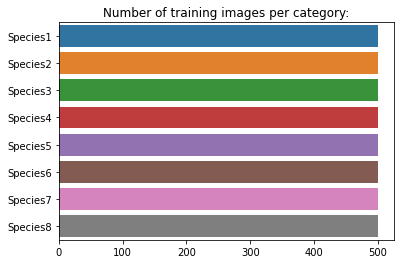

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
category_names = sorted(os.listdir(training_dir))
nb_categories = len(category_names)
img_pr_cat = []
for category in category_names:
    folder = training_dir + '/' + category
    img_pr_cat.append(len(os.listdir(folder)))
sns.barplot(y=category_names, x=img_pr_cat).set_title("Number of training images per category:")

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import array_to_img, img_to_array, load_img

# Create an instance of ImageDataGenerator with Data Augmentation
aug_train_data_gen = ImageDataGenerator(#rotation_range=180,
                                        height_shift_range=5,
                                        width_shift_range=5,
                                        #zoom_range=0.5,
                                        horizontal_flip=True,
                                        vertical_flip=True, 
                                        #fill_mode='nearest',
                                        preprocessing_function = preprocess_input,
                                        # rescale=1/255. not on vgg16
                                        ) 
valid_data_gen = ImageDataGenerator(#rescale=1/255.,
                                    preprocessing_function = preprocess_input)
test_data_gen = ImageDataGenerator(#rescale=1/255.,
                                   preprocessing_function = preprocess_input)

In [12]:
# Obtain a data generator with the 'ImageDataGenerator.flow_from_directory' method
aug_train_gen = aug_train_data_gen.flow_from_directory(directory=training_dir,
                                                       target_size=(96,96),
                                                       color_mode='rgb',
                                                       classes=None, # can be set to labels
                                                       class_mode='categorical',
                                                       batch_size=32,
                                                       shuffle=True,
                                                       seed=seed)

valid_gen = valid_data_gen.flow_from_directory(directory=validation_dir,
                                               target_size=(96,96),
                                               color_mode='rgb',
                                               classes=None, # can be set to labels
                                               class_mode='categorical',
                                               batch_size=32,
                                               shuffle=True,
                                               seed=seed)
test_gen = test_data_gen.flow_from_directory(directory=test_dir,
                                             target_size=(96,96),
                                             color_mode='rgb',
                                             classes=None, # can be set to labels
                                             class_mode='categorical',
                                             batch_size=32,
                                             shuffle=False,
                                             seed=seed)

Found 4000 images belonging to 8 classes.
Found 527 images belonging to 8 classes.
Found 361 images belonging to 8 classes.


In [13]:
def get_next_batch(generator):
  batch = next(generator)

  image = batch[0]
  target = batch[1]

  print("(Input) image shape:", image.shape)
  print("Target shape:",target.shape)

  # Visualize only the first sample
  image = image[0]
  target = target[0]
  target_idx = np.argmax(target)
  print()
  print("Categorical label:", target)
  print("Label:", target_idx)
  print("Class name:", labels[target_idx])
  fig = plt.figure(figsize=(6, 4))
  plt.imshow(np.uint8(image))

  return batch

(Input) image shape: (32, 96, 96, 3)
Target shape: (32, 8)

Categorical label: [0. 1. 0. 0. 0. 0. 0. 0.]
Label: 1
Class name: Species2


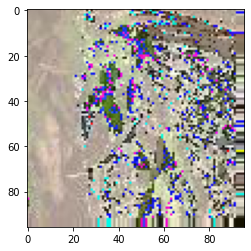

In [14]:
# Get a sample from dataset and show info
_ = get_next_batch(aug_train_gen)

In [15]:
# Utility function to create folders and callbacks for training
from datetime import datetime

def create_folders_and_callbacks(model_name):

  exps_dir = os.path.join('data_augmentation_experiments')
  if not os.path.exists(exps_dir):
      os.makedirs(exps_dir)

  now = datetime.now().strftime('%b%d_%H-%M-%S')

  exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
  if not os.path.exists(exp_dir):
      os.makedirs(exp_dir)
      
  callbacks = []

  # Model checkpoint
  # ----------------
  ckpt_dir = os.path.join(exp_dir, 'ckpts')
  if not os.path.exists(ckpt_dir):
      os.makedirs(ckpt_dir)

  ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp.ckpt'), 
                                                     save_weights_only=False, # True to save only weights
                                                     save_best_only=False) # True to save only the best epoch 
  callbacks.append(ckpt_callback)

  # Visualize Learning on Tensorboard
  # ---------------------------------
  tb_dir = os.path.join(exp_dir, 'tb_logs')
  if not os.path.exists(tb_dir):
      os.makedirs(tb_dir)
      
  # By default shows losses and metrics for both training and validation
  tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir, 
                                               profile_batch=0,
                                               histogram_freq=1)  # if > 0 (epochs) shows weights histograms
  callbacks.append(tb_callback)

  # Early Stopping
  # --------------
  es_callback  = tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True)
  callbacks.append(es_callback)

  return callbacks

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 96, 96, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 96, 96, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 48, 48, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 48, 48, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 48, 48, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 24, 24, 128)       0     

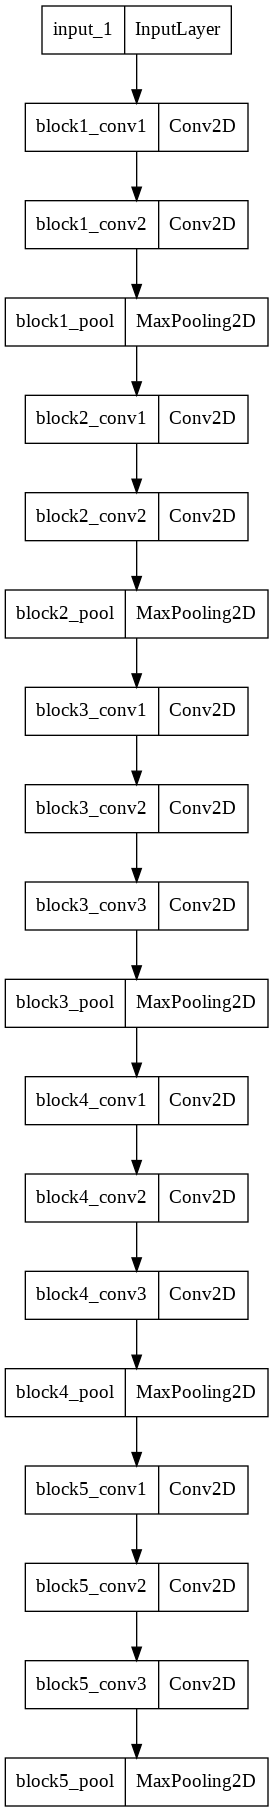

In [16]:
# Download and plot the VGG16 model
supernet = tfk.applications.VGG16(
    include_top=False,
    weights="imagenet",
    input_shape=(96,96,3)
)
supernet.summary()
tfk.utils.plot_model(supernet)

In [17]:
input_shape = (96, 96, 3)
epochs = 200

In [18]:
import tensorflow.keras.layers as tfkl

# Use the supernet as feature extractor
supernet.trainable = False

inputs = tfk.Input(shape=(96,96,3))
# No resize
#x = tfkl.Resizing(64, 64, interpolation="bicubic")(inputs)
x = supernet(inputs)
x = tfkl.Flatten(name='Flattening')(x)
x = tfkl.Dropout(0.3, seed=seed)(x)
x = tfkl.Dense(
    256, 
    activation='relu',
    kernel_initializer = tfk.initializers.GlorotUniform(seed))(x)
x = tfkl.Dropout(0.3, seed=seed)(x)
output_layer = tfkl.Dense(units=8, activation='softmax', kernel_initializer=tfk.initializers.GlorotUniform(seed), name='Output')(x)



# Connect input and output through the Model class
tl_model = tfk.Model(inputs=inputs, outputs=output_layer, name='model')

# Compile the model
tl_model.compile(loss='categorical_crossentropy', optimizer=tfk.optimizers.Adam(), metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
tl_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  
                                                                 
 Flattening (Flatten)        (None, 4608)              0         
                                                                 
 dropout (Dropout)           (None, 4608)              0         
                                                                 
 dense (Dense)               (None, 256)               1179904   
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 Output (Dense)              (None, 8)                 2056  

In [19]:
for i, layer in enumerate(tl_model.get_layer('vgg16').layers):
   layer.trainable = False

for i, layer in enumerate(tl_model.get_layer('vgg16').layers):
   print(i, layer.name, layer.trainable)

0 input_1 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 False
16 block5_conv2 False
17 block5_conv3 False
18 block5_pool False


In [20]:
# Train the model
tl_callbacks = create_folders_and_callbacks(model_name = 'transfer_learning')

# Train the model
tl_history = tl_model.fit(
    x = aug_train_gen,
    epochs = epochs,
    validation_data = valid_gen,
    callbacks = tl_callbacks,
    #class_weight=class_weight
).history

Epoch 1/200
125/125 [==============================] - ETA: 0s - loss: 3.6126 - accuracy: 0.3787 - precision: 0.4264 - recall: 0.2948

125/125 [==============================] - 30s 191ms/step - loss: 3.6126 - accuracy: 0.3787 - precision: 0.4264 - recall: 0.2948 - val_loss: 1.4789 - val_accuracy: 0.4459 - val_precision: 0.6575 - val_recall: 0.1822
Epoch 2/200
125/125 [==============================] - ETA: 0s - loss: 1.4859 - accuracy: 0.4843 - precision: 0.6163 - recall: 0.3240

125/125 [==============================] - 22s 173ms/step - loss: 1.4859 - accuracy: 0.4843 - precision: 0.6163 - recall: 0.3240 - val_loss: 1.2166 - val_accuracy: 0.5275 - val_precision: 0.7552 - val_recall: 0.2751
Epoch 3/200
125/125 [==============================] - ETA: 0s - loss: 1.3494 - accuracy: 0.5200 - precision: 0.6801 - recall: 0.3720

125/125 [==============================] - 22s 179ms/step - loss: 1.3494 - accuracy: 0.5200 - precision: 0.6801 - recall: 0.3720 - val_loss: 1.1416 - val_accuracy: 0.5617 - val_precision: 0.7735 - val_recall: 0.3435
Epoch 4/200
125/125 [==============================] - ETA: 0s - loss: 1.2460 - accuracy: 0.5400 - precision: 0.6872 - recall: 0.3983

125/125 [==============================] - 23s 180ms/step - loss: 1.2460 - accuracy: 0.5400 - precision: 0.6872 - recall: 0.3983 - val_loss: 1.1392 - val_accuracy: 0.6015 - val_precision: 0.7483 - val_recall: 0.4118
Epoch 5/200
125/125 [==============================] - ETA: 0s - loss: 1.1497 - accuracy: 0.5803 - precision: 0.7044 - recall: 0.4342

125/125 [==============================] - 22s 175ms/step - loss: 1.1497 - accuracy: 0.5803 - precision: 0.7044 - recall: 0.4342 - val_loss: 1.1298 - val_accuracy: 0.5806 - val_precision: 0.6968 - val_recall: 0.4099
Epoch 6/200
125/125 [==============================] - ETA: 0s - loss: 1.0965 - accuracy: 0.5922 - precision: 0.7209 - recall: 0.4745

125/125 [==============================] - 22s 180ms/step - loss: 1.0965 - accuracy: 0.5922 - precision: 0.7209 - recall: 0.4745 - val_loss: 1.0699 - val_accuracy: 0.5939 - val_precision: 0.7647 - val_recall: 0.3947
Epoch 7/200
125/125 [==============================] - ETA: 0s - loss: 1.0906 - accuracy: 0.6090 - precision: 0.7217 - recall: 0.4700

125/125 [==============================] - 22s 173ms/step - loss: 1.0906 - accuracy: 0.6090 - precision: 0.7217 - recall: 0.4700 - val_loss: 1.0049 - val_accuracy: 0.6110 - val_precision: 0.7151 - val_recall: 0.4763
Epoch 8/200
125/125 [==============================] - ETA: 0s - loss: 1.0534 - accuracy: 0.6187 - precision: 0.7252 - recall: 0.4988

125/125 [==============================] - 22s 177ms/step - loss: 1.0534 - accuracy: 0.6187 - precision: 0.7252 - recall: 0.4988 - val_loss: 1.0362 - val_accuracy: 0.6129 - val_precision: 0.7221 - val_recall: 0.4535
Epoch 9/200
125/125 [==============================] - ETA: 0s - loss: 1.0273 - accuracy: 0.6187 - precision: 0.7353 - recall: 0.5015

125/125 [==============================] - 23s 183ms/step - loss: 1.0273 - accuracy: 0.6187 - precision: 0.7353 - recall: 0.5015 - val_loss: 0.9687 - val_accuracy: 0.6243 - val_precision: 0.7674 - val_recall: 0.4820
Epoch 10/200
125/125 [==============================] - ETA: 0s - loss: 0.9722 - accuracy: 0.6320 - precision: 0.7476 - recall: 0.5155

125/125 [==============================] - 22s 174ms/step - loss: 0.9722 - accuracy: 0.6320 - precision: 0.7476 - recall: 0.5155 - val_loss: 1.0169 - val_accuracy: 0.6338 - val_precision: 0.7429 - val_recall: 0.5427
Epoch 11/200
125/125 [==============================] - ETA: 0s - loss: 0.9479 - accuracy: 0.6500 - precision: 0.7605 - recall: 0.5477

125/125 [==============================] - 22s 174ms/step - loss: 0.9479 - accuracy: 0.6500 - precision: 0.7605 - recall: 0.5477 - val_loss: 1.0103 - val_accuracy: 0.6186 - val_precision: 0.7405 - val_recall: 0.5199
Epoch 12/200
125/125 [==============================] - ETA: 0s - loss: 0.9499 - accuracy: 0.6505 - precision: 0.7515 - recall: 0.5330

125/125 [==============================] - 22s 178ms/step - loss: 0.9499 - accuracy: 0.6505 - precision: 0.7515 - recall: 0.5330 - val_loss: 0.9892 - val_accuracy: 0.5920 - val_precision: 0.7560 - val_recall: 0.4820
Epoch 13/200
125/125 [==============================] - ETA: 0s - loss: 0.9186 - accuracy: 0.6683 - precision: 0.7648 - recall: 0.5707

125/125 [==============================] - 22s 174ms/step - loss: 0.9186 - accuracy: 0.6683 - precision: 0.7648 - recall: 0.5707 - val_loss: 0.9797 - val_accuracy: 0.6224 - val_precision: 0.7570 - val_recall: 0.5142
Epoch 14/200
125/125 [==============================] - ETA: 0s - loss: 0.9272 - accuracy: 0.6687 - precision: 0.7580 - recall: 0.5537

125/125 [==============================] - 23s 186ms/step - loss: 0.9272 - accuracy: 0.6687 - precision: 0.7580 - recall: 0.5537 - val_loss: 0.9583 - val_accuracy: 0.6376 - val_precision: 0.7425 - val_recall: 0.5142
Epoch 15/200
125/125 [==============================] - ETA: 0s - loss: 0.9001 - accuracy: 0.6743 - precision: 0.7722 - recall: 0.5660

125/125 [==============================] - 22s 174ms/step - loss: 0.9001 - accuracy: 0.6743 - precision: 0.7722 - recall: 0.5660 - val_loss: 0.9842 - val_accuracy: 0.6509 - val_precision: 0.7771 - val_recall: 0.4896
Epoch 16/200
125/125 [==============================] - ETA: 0s - loss: 0.8585 - accuracy: 0.6865 - precision: 0.7841 - recall: 0.5875

125/125 [==============================] - 22s 175ms/step - loss: 0.8585 - accuracy: 0.6865 - precision: 0.7841 - recall: 0.5875 - val_loss: 1.0312 - val_accuracy: 0.6338 - val_precision: 0.7189 - val_recall: 0.5047
Epoch 17/200
125/125 [==============================] - ETA: 0s - loss: 0.8783 - accuracy: 0.6747 - precision: 0.7760 - recall: 0.5847

125/125 [==============================] - 23s 181ms/step - loss: 0.8783 - accuracy: 0.6747 - precision: 0.7760 - recall: 0.5847 - val_loss: 1.0372 - val_accuracy: 0.6091 - val_precision: 0.7193 - val_recall: 0.5009
Epoch 18/200
125/125 [==============================] - ETA: 0s - loss: 0.8565 - accuracy: 0.6873 - precision: 0.7778 - recall: 0.5943

125/125 [==============================] - 21s 171ms/step - loss: 0.8565 - accuracy: 0.6873 - precision: 0.7778 - recall: 0.5943 - val_loss: 1.0217 - val_accuracy: 0.6338 - val_precision: 0.7659 - val_recall: 0.5028
Epoch 19/200
125/125 [==============================] - ETA: 0s - loss: 0.8644 - accuracy: 0.6837 - precision: 0.7803 - recall: 0.5867

125/125 [==============================] - 22s 172ms/step - loss: 0.8644 - accuracy: 0.6837 - precision: 0.7803 - recall: 0.5867 - val_loss: 0.9766 - val_accuracy: 0.6224 - val_precision: 0.7316 - val_recall: 0.5275
Epoch 20/200
125/125 [==============================] - ETA: 0s - loss: 0.8288 - accuracy: 0.7020 - precision: 0.7972 - recall: 0.6075

125/125 [==============================] - 23s 181ms/step - loss: 0.8288 - accuracy: 0.7020 - precision: 0.7972 - recall: 0.6075 - val_loss: 0.9578 - val_accuracy: 0.6243 - val_precision: 0.7321 - val_recall: 0.5446
Epoch 21/200
125/125 [==============================] - ETA: 0s - loss: 0.8669 - accuracy: 0.6795 - precision: 0.7780 - recall: 0.5835

125/125 [==============================] - 22s 174ms/step - loss: 0.8669 - accuracy: 0.6795 - precision: 0.7780 - recall: 0.5835 - val_loss: 0.9354 - val_accuracy: 0.6243 - val_precision: 0.7412 - val_recall: 0.5218
Epoch 22/200
125/125 [==============================] - ETA: 0s - loss: 0.8150 - accuracy: 0.7038 - precision: 0.7941 - recall: 0.6140

125/125 [==============================] - 22s 179ms/step - loss: 0.8150 - accuracy: 0.7038 - precision: 0.7941 - recall: 0.6140 - val_loss: 0.9386 - val_accuracy: 0.6528 - val_precision: 0.7589 - val_recall: 0.5256
Epoch 23/200
125/125 [==============================] - ETA: 0s - loss: 0.8090 - accuracy: 0.7038 - precision: 0.7933 - recall: 0.6133

125/125 [==============================] - 22s 173ms/step - loss: 0.8090 - accuracy: 0.7038 - precision: 0.7933 - recall: 0.6133 - val_loss: 0.9964 - val_accuracy: 0.6281 - val_precision: 0.7150 - val_recall: 0.5332
Epoch 24/200
125/125 [==============================] - ETA: 0s - loss: 0.7734 - accuracy: 0.7113 - precision: 0.7963 - recall: 0.6285

125/125 [==============================] - 21s 172ms/step - loss: 0.7734 - accuracy: 0.7113 - precision: 0.7963 - recall: 0.6285 - val_loss: 0.9734 - val_accuracy: 0.6433 - val_precision: 0.7910 - val_recall: 0.5313
Epoch 25/200
125/125 [==============================] - ETA: 0s - loss: 0.7733 - accuracy: 0.7168 - precision: 0.8038 - recall: 0.6340

125/125 [==============================] - 23s 182ms/step - loss: 0.7733 - accuracy: 0.7168 - precision: 0.8038 - recall: 0.6340 - val_loss: 1.0040 - val_accuracy: 0.6433 - val_precision: 0.7532 - val_recall: 0.5503
Epoch 26/200
125/125 [==============================] - ETA: 0s - loss: 0.7625 - accuracy: 0.7225 - precision: 0.8009 - recall: 0.6345

125/125 [==============================] - 21s 172ms/step - loss: 0.7625 - accuracy: 0.7225 - precision: 0.8009 - recall: 0.6345 - val_loss: 1.0128 - val_accuracy: 0.6433 - val_precision: 0.7397 - val_recall: 0.5769
Epoch 27/200
125/125 [==============================] - ETA: 0s - loss: 0.7772 - accuracy: 0.7168 - precision: 0.7966 - recall: 0.6392

125/125 [==============================] - 22s 180ms/step - loss: 0.7772 - accuracy: 0.7168 - precision: 0.7966 - recall: 0.6392 - val_loss: 1.0835 - val_accuracy: 0.6186 - val_precision: 0.7205 - val_recall: 0.5332
Epoch 28/200
125/125 [==============================] - ETA: 0s - loss: 0.7759 - accuracy: 0.7195 - precision: 0.8000 - recall: 0.6330

125/125 [==============================] - 22s 175ms/step - loss: 0.7759 - accuracy: 0.7195 - precision: 0.8000 - recall: 0.6330 - val_loss: 0.9868 - val_accuracy: 0.6338 - val_precision: 0.7416 - val_recall: 0.5446
Epoch 29/200
125/125 [==============================] - ETA: 0s - loss: 0.7494 - accuracy: 0.7330 - precision: 0.8184 - recall: 0.6455

125/125 [==============================] - 24s 196ms/step - loss: 0.7494 - accuracy: 0.7330 - precision: 0.8184 - recall: 0.6455 - val_loss: 0.9709 - val_accuracy: 0.6546 - val_precision: 0.7481 - val_recall: 0.5636
Epoch 30/200
125/125 [==============================] - ETA: 0s - loss: 0.7648 - accuracy: 0.7255 - precision: 0.8020 - recall: 0.6482

125/125 [==============================] - 21s 172ms/step - loss: 0.7648 - accuracy: 0.7255 - precision: 0.8020 - recall: 0.6482 - val_loss: 0.9639 - val_accuracy: 0.6603 - val_precision: 0.7556 - val_recall: 0.5806
Epoch 31/200
125/125 [==============================] - ETA: 0s - loss: 0.7541 - accuracy: 0.7268 - precision: 0.8118 - recall: 0.6513

125/125 [==============================] - 22s 173ms/step - loss: 0.7541 - accuracy: 0.7268 - precision: 0.8118 - recall: 0.6513 - val_loss: 0.9831 - val_accuracy: 0.6603 - val_precision: 0.7354 - val_recall: 0.5484
Epoch 32/200
125/125 [==============================] - ETA: 0s - loss: 0.7516 - accuracy: 0.7207 - precision: 0.8072 - recall: 0.6470

125/125 [==============================] - 23s 183ms/step - loss: 0.7516 - accuracy: 0.7207 - precision: 0.8072 - recall: 0.6470 - val_loss: 0.9692 - val_accuracy: 0.6584 - val_precision: 0.7364 - val_recall: 0.5408
Epoch 33/200
125/125 [==============================] - ETA: 0s - loss: 0.7655 - accuracy: 0.7297 - precision: 0.8040 - recall: 0.6490

125/125 [==============================] - 22s 175ms/step - loss: 0.7655 - accuracy: 0.7297 - precision: 0.8040 - recall: 0.6490 - val_loss: 0.9788 - val_accuracy: 0.6471 - val_precision: 0.7449 - val_recall: 0.5598
Epoch 34/200
125/125 [==============================] - ETA: 0s - loss: 0.7483 - accuracy: 0.7322 - precision: 0.8152 - recall: 0.6530

125/125 [==============================] - 21s 171ms/step - loss: 0.7483 - accuracy: 0.7322 - precision: 0.8152 - recall: 0.6530 - val_loss: 1.0373 - val_accuracy: 0.6319 - val_precision: 0.7255 - val_recall: 0.5617
Epoch 35/200
125/125 [==============================] - ETA: 0s - loss: 0.7245 - accuracy: 0.7293 - precision: 0.8084 - recall: 0.6518

125/125 [==============================] - 23s 180ms/step - loss: 0.7245 - accuracy: 0.7293 - precision: 0.8084 - recall: 0.6518 - val_loss: 0.9638 - val_accuracy: 0.6793 - val_precision: 0.7482 - val_recall: 0.5806
Epoch 36/200
125/125 [==============================] - ETA: 0s - loss: 0.7326 - accuracy: 0.7375 - precision: 0.8110 - recall: 0.6565

125/125 [==============================] - 21s 171ms/step - loss: 0.7326 - accuracy: 0.7375 - precision: 0.8110 - recall: 0.6565 - val_loss: 0.9774 - val_accuracy: 0.6433 - val_precision: 0.7273 - val_recall: 0.5617
Epoch 37/200
125/125 [==============================] - ETA: 0s - loss: 0.7317 - accuracy: 0.7370 - precision: 0.8166 - recall: 0.6612

125/125 [==============================] - 23s 182ms/step - loss: 0.7317 - accuracy: 0.7370 - precision: 0.8166 - recall: 0.6612 - val_loss: 0.9580 - val_accuracy: 0.6717 - val_precision: 0.7757 - val_recall: 0.5579
Epoch 38/200
125/125 [==============================] - ETA: 0s - loss: 0.7297 - accuracy: 0.7408 - precision: 0.8167 - recall: 0.6628

125/125 [==============================] - 21s 170ms/step - loss: 0.7297 - accuracy: 0.7408 - precision: 0.8167 - recall: 0.6628 - val_loss: 1.0176 - val_accuracy: 0.6471 - val_precision: 0.7327 - val_recall: 0.5617
Epoch 39/200
125/125 [==============================] - ETA: 0s - loss: 0.7291 - accuracy: 0.7410 - precision: 0.8229 - recall: 0.6655

125/125 [==============================] - 22s 174ms/step - loss: 0.7291 - accuracy: 0.7410 - precision: 0.8229 - recall: 0.6655 - val_loss: 0.9573 - val_accuracy: 0.6812 - val_precision: 0.7658 - val_recall: 0.5522
Epoch 40/200
125/125 [==============================] - ETA: 0s - loss: 0.7259 - accuracy: 0.7442 - precision: 0.8198 - recall: 0.6678

125/125 [==============================] - 23s 181ms/step - loss: 0.7259 - accuracy: 0.7442 - precision: 0.8198 - recall: 0.6678 - val_loss: 0.9224 - val_accuracy: 0.6528 - val_precision: 0.7649 - val_recall: 0.5617
Epoch 41/200
125/125 [==============================] - ETA: 0s - loss: 0.7078 - accuracy: 0.7490 - precision: 0.8194 - recall: 0.6783

125/125 [==============================] - 22s 173ms/step - loss: 0.7078 - accuracy: 0.7490 - precision: 0.8194 - recall: 0.6783 - val_loss: 0.9891 - val_accuracy: 0.6812 - val_precision: 0.7589 - val_recall: 0.6034
Epoch 42/200
125/125 [==============================] - ETA: 0s - loss: 0.6916 - accuracy: 0.7460 - precision: 0.8163 - recall: 0.6810

125/125 [==============================] - 22s 175ms/step - loss: 0.6916 - accuracy: 0.7460 - precision: 0.8163 - recall: 0.6810 - val_loss: 0.9709 - val_accuracy: 0.6660 - val_precision: 0.7312 - val_recall: 0.5731
Epoch 43/200
125/125 [==============================] - ETA: 0s - loss: 0.7161 - accuracy: 0.7495 - precision: 0.8239 - recall: 0.6798

125/125 [==============================] - 23s 181ms/step - loss: 0.7161 - accuracy: 0.7495 - precision: 0.8239 - recall: 0.6798 - val_loss: 0.9943 - val_accuracy: 0.6509 - val_precision: 0.7244 - val_recall: 0.5636
Epoch 44/200
125/125 [==============================] - ETA: 0s - loss: 0.7332 - accuracy: 0.7465 - precision: 0.8228 - recall: 0.6722

125/125 [==============================] - 21s 170ms/step - loss: 0.7332 - accuracy: 0.7465 - precision: 0.8228 - recall: 0.6722 - val_loss: 0.9324 - val_accuracy: 0.6471 - val_precision: 0.7457 - val_recall: 0.5731
Epoch 45/200
125/125 [==============================] - ETA: 0s - loss: 0.6955 - accuracy: 0.7465 - precision: 0.8256 - recall: 0.6783

125/125 [==============================] - 22s 179ms/step - loss: 0.6955 - accuracy: 0.7465 - precision: 0.8256 - recall: 0.6783 - val_loss: 0.9604 - val_accuracy: 0.6831 - val_precision: 0.7548 - val_recall: 0.6015
Epoch 46/200
125/125 [==============================] - ETA: 0s - loss: 0.7141 - accuracy: 0.7505 - precision: 0.8174 - recall: 0.6837

125/125 [==============================] - 22s 174ms/step - loss: 0.7141 - accuracy: 0.7505 - precision: 0.8174 - recall: 0.6837 - val_loss: 0.9471 - val_accuracy: 0.6698 - val_precision: 0.7587 - val_recall: 0.5787
Epoch 47/200
125/125 [==============================] - ETA: 0s - loss: 0.6842 - accuracy: 0.7605 - precision: 0.8330 - recall: 0.6970

125/125 [==============================] - 22s 173ms/step - loss: 0.6842 - accuracy: 0.7605 - precision: 0.8330 - recall: 0.6970 - val_loss: 1.0025 - val_accuracy: 0.6717 - val_precision: 0.7366 - val_recall: 0.5996
Epoch 48/200
125/125 [==============================] - ETA: 0s - loss: 0.6897 - accuracy: 0.7535 - precision: 0.8209 - recall: 0.6908

125/125 [==============================] - 22s 179ms/step - loss: 0.6897 - accuracy: 0.7535 - precision: 0.8209 - recall: 0.6908 - val_loss: 0.9961 - val_accuracy: 0.6565 - val_precision: 0.7293 - val_recall: 0.5674
Epoch 49/200
125/125 [==============================] - ETA: 0s - loss: 0.7022 - accuracy: 0.7523 - precision: 0.8237 - recall: 0.6750

125/125 [==============================] - 22s 173ms/step - loss: 0.7022 - accuracy: 0.7523 - precision: 0.8237 - recall: 0.6750 - val_loss: 0.9637 - val_accuracy: 0.6812 - val_precision: 0.7685 - val_recall: 0.5920
Epoch 50/200
125/125 [==============================] - ETA: 0s - loss: 0.6894 - accuracy: 0.7590 - precision: 0.8334 - recall: 0.6915

125/125 [==============================] - 21s 172ms/step - loss: 0.6894 - accuracy: 0.7590 - precision: 0.8334 - recall: 0.6915 - val_loss: 0.9473 - val_accuracy: 0.6698 - val_precision: 0.7530 - val_recall: 0.5958
Epoch 51/200
125/125 [==============================] - ETA: 0s - loss: 0.6814 - accuracy: 0.7580 - precision: 0.8278 - recall: 0.6910

125/125 [==============================] - 23s 182ms/step - loss: 0.6814 - accuracy: 0.7580 - precision: 0.8278 - recall: 0.6910 - val_loss: 0.9599 - val_accuracy: 0.6698 - val_precision: 0.7550 - val_recall: 0.5731
Epoch 52/200
125/125 [==============================] - ETA: 0s - loss: 0.6848 - accuracy: 0.7560 - precision: 0.8245 - recall: 0.6860

125/125 [==============================] - 21s 170ms/step - loss: 0.6848 - accuracy: 0.7560 - precision: 0.8245 - recall: 0.6860 - val_loss: 0.9458 - val_accuracy: 0.6793 - val_precision: 0.7694 - val_recall: 0.5825
Epoch 53/200
125/125 [==============================] - ETA: 0s - loss: 0.6794 - accuracy: 0.7515 - precision: 0.8254 - recall: 0.6890

125/125 [==============================] - 22s 180ms/step - loss: 0.6794 - accuracy: 0.7515 - precision: 0.8254 - recall: 0.6890 - val_loss: 0.9222 - val_accuracy: 0.6641 - val_precision: 0.7952 - val_recall: 0.5674
Epoch 54/200
125/125 [==============================] - ETA: 0s - loss: 0.6787 - accuracy: 0.7640 - precision: 0.8295 - recall: 0.6967

125/125 [==============================] - 21s 171ms/step - loss: 0.6787 - accuracy: 0.7640 - precision: 0.8295 - recall: 0.6967 - val_loss: 0.8976 - val_accuracy: 0.6774 - val_precision: 0.7621 - val_recall: 0.5958
Epoch 55/200
125/125 [==============================] - ETA: 0s - loss: 0.6778 - accuracy: 0.7613 - precision: 0.8315 - recall: 0.6923

125/125 [==============================] - 21s 171ms/step - loss: 0.6778 - accuracy: 0.7613 - precision: 0.8315 - recall: 0.6923 - val_loss: 0.9300 - val_accuracy: 0.6850 - val_precision: 0.7599 - val_recall: 0.5825
Epoch 56/200
125/125 [==============================] - ETA: 0s - loss: 0.6497 - accuracy: 0.7735 - precision: 0.8338 - recall: 0.7113

125/125 [==============================] - 23s 183ms/step - loss: 0.6497 - accuracy: 0.7735 - precision: 0.8338 - recall: 0.7113 - val_loss: 0.9658 - val_accuracy: 0.6565 - val_precision: 0.7463 - val_recall: 0.5693
Epoch 57/200
125/125 [==============================] - ETA: 0s - loss: 0.6512 - accuracy: 0.7670 - precision: 0.8322 - recall: 0.6955

125/125 [==============================] - 22s 172ms/step - loss: 0.6512 - accuracy: 0.7670 - precision: 0.8322 - recall: 0.6955 - val_loss: 0.9815 - val_accuracy: 0.6717 - val_precision: 0.7426 - val_recall: 0.5750
Epoch 58/200
125/125 [==============================] - ETA: 0s - loss: 0.6233 - accuracy: 0.7780 - precision: 0.8444 - recall: 0.7107

125/125 [==============================] - 21s 170ms/step - loss: 0.6233 - accuracy: 0.7780 - precision: 0.8444 - recall: 0.7107 - val_loss: 0.9563 - val_accuracy: 0.6622 - val_precision: 0.7581 - val_recall: 0.5769
Epoch 59/200
125/125 [==============================] - ETA: 0s - loss: 0.6517 - accuracy: 0.7710 - precision: 0.8394 - recall: 0.7017

125/125 [==============================] - 22s 180ms/step - loss: 0.6517 - accuracy: 0.7710 - precision: 0.8394 - recall: 0.7017 - val_loss: 0.9644 - val_accuracy: 0.6717 - val_precision: 0.7512 - val_recall: 0.5844
Epoch 60/200
125/125 [==============================] - ETA: 0s - loss: 0.6537 - accuracy: 0.7678 - precision: 0.8366 - recall: 0.6975

125/125 [==============================] - 21s 169ms/step - loss: 0.6537 - accuracy: 0.7678 - precision: 0.8366 - recall: 0.6975 - val_loss: 1.0129 - val_accuracy: 0.6679 - val_precision: 0.7445 - val_recall: 0.5806
Epoch 61/200
125/125 [==============================] - ETA: 0s - loss: 0.6214 - accuracy: 0.7818 - precision: 0.8466 - recall: 0.7218

125/125 [==============================] - 22s 179ms/step - loss: 0.6214 - accuracy: 0.7818 - precision: 0.8466 - recall: 0.7218 - val_loss: 0.9889 - val_accuracy: 0.6850 - val_precision: 0.7423 - val_recall: 0.5958
Epoch 62/200
125/125 [==============================] - ETA: 0s - loss: 0.6498 - accuracy: 0.7707 - precision: 0.8363 - recall: 0.7113

125/125 [==============================] - 22s 175ms/step - loss: 0.6498 - accuracy: 0.7707 - precision: 0.8363 - recall: 0.7113 - val_loss: 1.0260 - val_accuracy: 0.6622 - val_precision: 0.7388 - val_recall: 0.5958
Epoch 63/200
125/125 [==============================] - ETA: 0s - loss: 0.6739 - accuracy: 0.7725 - precision: 0.8357 - recall: 0.7110

125/125 [==============================] - 21s 172ms/step - loss: 0.6739 - accuracy: 0.7725 - precision: 0.8357 - recall: 0.7110 - val_loss: 0.9458 - val_accuracy: 0.6622 - val_precision: 0.7670 - val_recall: 0.5560
Epoch 64/200
125/125 [==============================] - ETA: 0s - loss: 0.5914 - accuracy: 0.7940 - precision: 0.8579 - recall: 0.7322

125/125 [==============================] - 22s 178ms/step - loss: 0.5914 - accuracy: 0.7940 - precision: 0.8579 - recall: 0.7322 - val_loss: 0.9782 - val_accuracy: 0.6660 - val_precision: 0.7617 - val_recall: 0.5882
Epoch 65/200
125/125 [==============================] - ETA: 0s - loss: 0.6512 - accuracy: 0.7725 - precision: 0.8442 - recall: 0.7055

125/125 [==============================] - 21s 171ms/step - loss: 0.6512 - accuracy: 0.7725 - precision: 0.8442 - recall: 0.7055 - val_loss: 0.9982 - val_accuracy: 0.6565 - val_precision: 0.7625 - val_recall: 0.5787


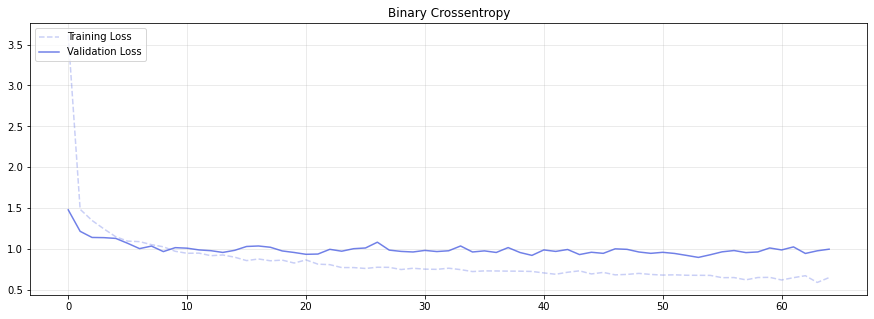

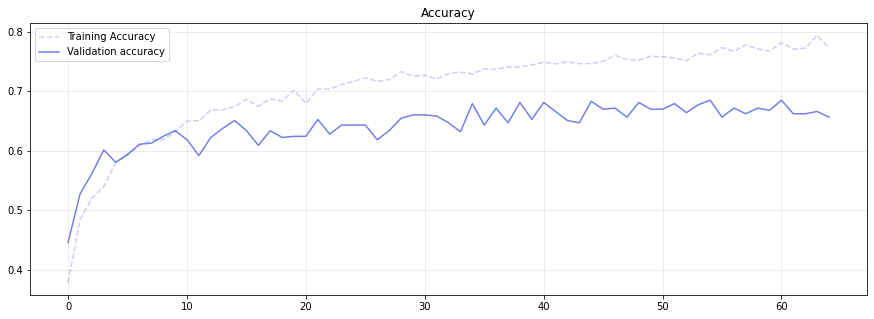

In [21]:
# Plot the training
plt.figure(figsize=(15,5))

plt.plot(tl_history['loss'],label = 'Training Loss', alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_loss'], label='Validation Loss', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Binary Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))

plt.plot(tl_history['accuracy'],label = 'Training Accuracy' , alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_accuracy'], label='Validation accuracy', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [22]:
tl_model.save('Vgg16/FineFineTuning_v1')

In [23]:
tl_model = tfk.models.load_model('Vgg16/FineFineTuning_v1')
tl_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  
                                                                 
 Flattening (Flatten)        (None, 4608)              0         
                                                                 
 dropout (Dropout)           (None, 4608)              0         
                                                                 
 dense (Dense)               (None, 256)               1179904   
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 Output (Dense)              (None, 8)                 2056  

In [24]:
tl_model.get_layer('vgg16').trainable = True
for i, layer in enumerate(tl_model.get_layer('vgg16').layers):
   print(i, layer.name, layer.trainable)

0 input_1 True
1 block1_conv1 True
2 block1_conv2 True
3 block1_pool True
4 block2_conv1 True
5 block2_conv2 True
6 block2_pool True
7 block3_conv1 True
8 block3_conv2 True
9 block3_conv3 True
10 block3_pool True
11 block4_conv1 True
12 block4_conv2 True
13 block4_conv3 True
14 block4_pool True
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True


In [25]:
for i, layer in enumerate(tl_model.get_layer('vgg16').layers[:15]):
  layer.trainable=False
for i, layer in enumerate(tl_model.get_layer('vgg16').layers):
   print(i, layer.name, layer.trainable)
tl_model.summary()

0 input_1 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  
                                                                 
 Flattening (Flatten)        (None, 4608)              0         
                                                                 
 dropout (Dropout)           (None, 4608)              0       

In [26]:
tl_model.compile(loss='categorical_crossentropy', optimizer=tfk.optimizers.Adam(1e-4), metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [27]:
# Fine-tune the model
tl_history = tl_model.fit(
    x = aug_train_gen ,
    batch_size = 32,
    epochs = 200,
    validation_data = valid_gen,
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, verbose=2 , restore_best_weights=True)],
    #class_weight = class_weight
).history

Epoch 1/200
125/125 [==============================] - 19s 137ms/step - loss: 1.0906 - accuracy: 0.6400 - precision_1: 0.7375 - recall_1: 0.5360 - val_loss: 1.1164 - val_accuracy: 0.6319 - val_precision_1: 0.7225 - val_recall_1: 0.5484
Epoch 2/200
125/125 [==============================] - 17s 132ms/step - loss: 0.9066 - accuracy: 0.6950 - precision_1: 0.7856 - recall_1: 0.6047 - val_loss: 0.9738 - val_accuracy: 0.6452 - val_precision_1: 0.7601 - val_recall_1: 0.5351
Epoch 3/200
125/125 [==============================] - 17s 139ms/step - loss: 0.7636 - accuracy: 0.7287 - precision_1: 0.8058 - recall_1: 0.6525 - val_loss: 0.9010 - val_accuracy: 0.7097 - val_precision_1: 0.8000 - val_recall_1: 0.5996
Epoch 4/200
125/125 [==============================] - 17s 132ms/step - loss: 0.7331 - accuracy: 0.7458 - precision_1: 0.8218 - recall_1: 0.6735 - val_loss: 0.8768 - val_accuracy: 0.7021 - val_precision_1: 0.8024 - val_recall_1: 0.6243
Epoch 5/200
125/125 [==============================] - 1

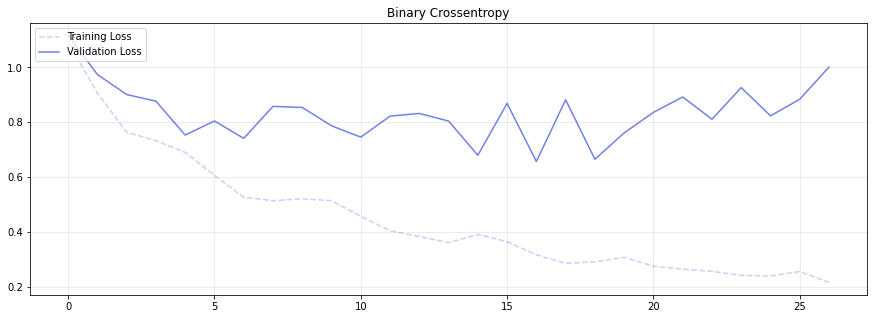

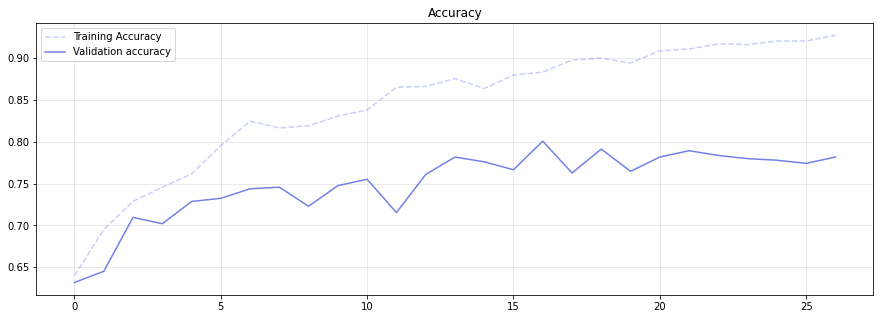

In [28]:
# Plot the training
plt.figure(figsize=(15,5))

plt.plot(tl_history['loss'],label = 'Training Loss', alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_loss'], label='Validation Loss', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Binary Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))

plt.plot(tl_history['accuracy'],label = 'Training Accuracy' , alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_accuracy'], label='Validation accuracy', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [29]:
%cd /gdrive/My Drive/ANDL/Homework_1

/gdrive/My Drive/ANDL/Homework_1


In [30]:
tl_model.save('Vgg16/Tuned_v1_1')

In [31]:
# Test the model
tl_model = tfk.models.load_model("Vgg16/Tuned_v1_1")
model_test_metrics = tl_model.evaluate(test_gen, return_dict=True)

print()
print("Test metrics")
print(model_test_metrics)

12/12 [==============================] - 1s 90ms/step - loss: 0.6220 - accuracy: 0.8172 - precision_1: 0.8532 - recall_1: 0.7729

Test metrics
{'loss': 0.6219658851623535, 'accuracy': 0.81717449426651, 'precision_1': 0.853210985660553, 'recall_1': 0.7728531956672668}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """


Accuracy: 0.8172
Precision: 0.8327
Recall: 0.7932
F1: 0.8058


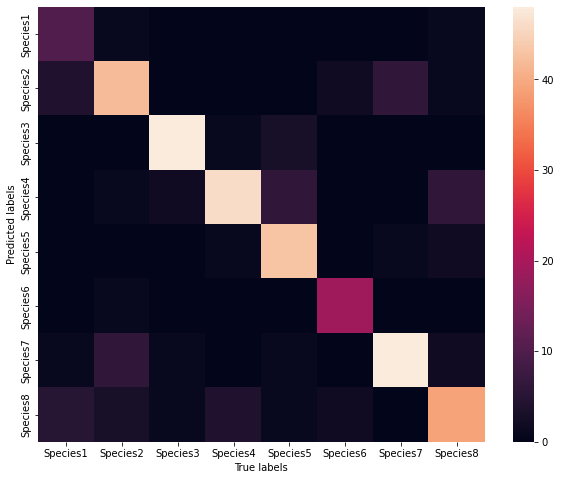

In [32]:
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix

predictions = tl_model.predict_generator(test_gen, steps=224)
predicted_classes = np.argmax(predictions, axis=-1)

# Compute the confusion matrix
cm = (confusion_matrix(test_gen.classes, predicted_classes))

# Compute the classification metrics
accuracy = accuracy_score(test_gen.classes, predicted_classes)
precision = precision_score(test_gen.classes, predicted_classes, average='macro')
recall = recall_score(test_gen.classes, predicted_classes, average='macro')
f1 = f1_score(test_gen.classes, predicted_classes, average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, xticklabels=labels, yticklabels=labels)
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()